In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date

random_seed = 42

In [50]:
date_parser = lambda x : datetime.strptime(x, "%d/%m/%Y %H:%M:%S")
df = pd.read_csv("./data/Modelar_UH2021.txt", sep="|", parse_dates=['fecha'],
                 date_parser=date_parser)

## 1. Análisis de Datos

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4045022 entries, 0 to 4045021
Data columns (total 11 columns):
 #   Column             Dtype         
---  ------             -----         
 0   fecha              datetime64[ns]
 1   id                 int64         
 2   visitas            int64         
 3   categoria_uno      object        
 4   categoria_dos      float64       
 5   estado             object        
 6   precio             object        
 7   dia_atipico        int64         
 8   campaña            int64         
 9   antiguedad         float64       
 10  unidades_vendidas  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(3)
memory usage: 339.5+ MB


In [52]:
df.head()

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,2015-06-01,21972,0,C,75.0,No Rotura,NaN,0,0,5241.0,0
1,2015-06-01,23910,5,C,170.0,No Rotura,"6,07",0,0,5241.0,3
2,2015-06-01,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
3,2015-06-01,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
4,2015-06-01,27144,15,E,230.0,No Rotura,NaN,0,0,4064.0,0


<hr>

* Atributo `fecha`

In [53]:
print("Numero de días en el dataset (", df['fecha'][0], "-", df['fecha'][len(df)-1], ": ",len(df['fecha'].unique()))

Numero de días en el dataset ( 2015-06-01 00:00:00 - 2016-09-30 00:00:00 :  487


¿Qué día de la semana agrupa más compras? ¿Qué mes del año?

In [54]:
df["weekday"] = df["fecha"].map(lambda x: x.weekday()) # Lunes = 0; Domingo = 6

ventas_per_weekday = df.groupby(["weekday"])["unidades_vendidas"].sum() / df["weekday"].value_counts()

0    5.085910
1    3.221597
2    2.488583
3    4.656646
4    5.759343
5    6.173217
6    5.507114
dtype: float64


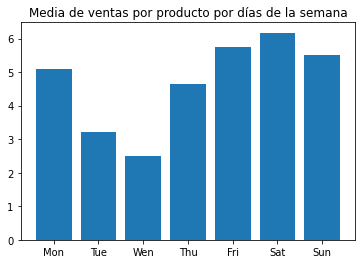

In [55]:
print(ventas_per_weekday)
plt.bar(range(0,7), ventas_per_weekday.values)
plt.title("Media de ventas por producto por días de la semana")
plt.xticks(range(0,7), ["Mon", "Tue", "Wen", "Thu", "Fri", "Sat", "Sun"])
plt.show()

Los resultados indican que los días en los que más se venden productos son los viernes, sábados y domingos.

In [56]:
df["month"] = df["fecha"].map(lambda x: x.month)
ventas_per_month = df.groupby(["month"])["unidades_vendidas"].sum() / df["month"].value_counts()

1      5.237830
2      4.341917
3      3.970224
4      3.764881
5      3.977774
6      3.484608
7      4.863620
8      3.456875
9      4.241843
10     4.014661
11    10.989706
12     6.736071
dtype: float64


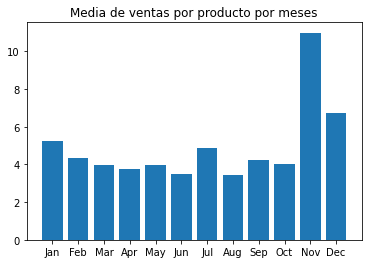

In [57]:
print(ventas_per_month)
plt.bar(range(0,12), ventas_per_month.values)
plt.title("Media de ventas por producto por meses")
plt.xticks(range(0,12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

Se obtiene que los meses Noviembre, Diciembre y Enero son los más exitosos en cuanto a ventas

¿Cómo queda la relación entre meses y días de la semana? Se crea un 'heatmap' para visualizarlo:

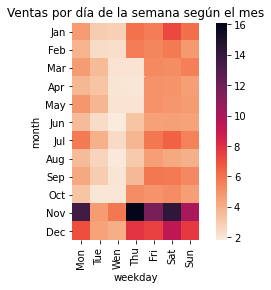

In [58]:
import seaborn as sns

piv = pd.pivot_table(df, values="unidades_vendidas",index=["month"], columns=["weekday"], fill_value=0)

ax = sns.heatmap(piv, cmap = sns.cm.rocket_r, square=True, 
                 xticklabels=["Mon", "Tue", "Wen", "Thu", "Fri", "Sat", "Sun"],
                 yticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.title("Ventas por día de la semana según el mes")
plt.show()

Parecen ser atributos que pueden ayudar a la hora de predecir el número de unidades vendidas. Se mantendrán en el dataframe.

¿Afecta al número de ventas que sea principio o final de mes? Partiendo de la suposición de que el pago de la nómina se realiza en los cinco primeros días del mes siguiente del devengo. 

In [59]:
dias_mes = {}
for y in [2015, 2016]:
    dias_mes[y]=[]
    for m in range(1,13):
        # Cálculo de ultimo dia del mes
        next_m = m+1 if m < 12 else 1
        next_y = y if m < 12 else y+1
        last_day = date(next_y, next_m, 1) - date(y, m, 1)
        # Lista con cinco últimos días para mes y año concreto
        dias_mes[y].append([last_day.days,last_day.days-1,last_day.days-2,last_day.days-3,last_day.days-4])

> Fin de mes:

In [60]:
df["fin_de_mes"] = df["fecha"].map(lambda x: x.day in dias_mes[x.year][x.month-1])
ventas_fin_mes = df.groupby(["fin_de_mes"])["unidades_vendidas"].sum() / df["fin_de_mes"].value_counts()

fin_de_mes
False    4.726018
True     4.525150
dtype: float64


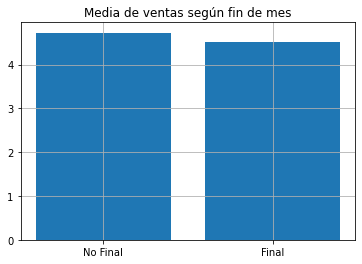

In [61]:
print(ventas_fin_mes)
plt.bar(range(0,2), ventas_fin_mes.values)
plt.title("Media de ventas según fin de mes")
plt.xticks(range(0,2), ["No Final", "Final"])
plt.grid()
plt.show()

> Inicio de mes:

In [62]:
df["principio_de_mes"] = df["fecha"].map(lambda x: x.day in range(1,6))
ventas_ini_mes = df.groupby(["principio_de_mes"])["unidades_vendidas"].sum() / df["principio_de_mes"].value_counts()

principio_de_mes
False    4.645257
True     4.938537
dtype: float64


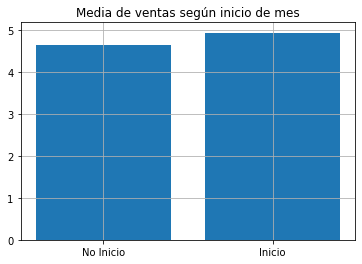

In [63]:
print(ventas_ini_mes)
plt.bar(range(0,2), ventas_ini_mes.values)
plt.title("Media de ventas según inicio de mes")
plt.xticks(range(0,2), ["No Inicio", "Inicio"])
plt.grid()
plt.show()

No parece que estos atributos puedan dar pistas sobre el número de unidades vendiadas para cada día. Se descartan:

In [64]:
df.drop(["principio_de_mes", "fin_de_mes"], axis=1, inplace=True)

<hr>

* Atributos `categoria_uno` y `estado`

In [65]:
df["categoria_uno"].value_counts()

A    1571062
K     581478
H     489922
F     458267
E     322394
G     174346
C     173372
L     115419
B      78407
I      67206
O       7305
N       5357
D        487
Name: categoria_uno, dtype: int64

In [66]:
df["estado"].value_counts()

No Rotura    3388184
Rotura        606530
Transito       50308
Name: estado, dtype: int64

In [67]:
df['estado'] = df['estado'].astype('category')
df['categoria_uno'] = df['categoria_uno'].astype('category')

En lugar de que sean objetos, que sean categorías que es un tipo más eficiente para estos tipos de datos

In [68]:
df['categoria_uno'].dtype

CategoricalDtype(categories=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N',
                  'O'],
                 ordered=False)

In [69]:
df["estado"].dtype

CategoricalDtype(categories=['No Rotura', 'Rotura', 'Transito'], ordered=False)

`estado` se puede transformar en tres atributos binarios al ser un atributo categórico nominal utilizando dummy encoders.

In [70]:
df["rotura"] = df["estado"].map(lambda x: 1 if x=='Rotura' else 0).astype('category')
df["no_rotura"] = df["estado"].map(lambda x: 1 if x=='No Rotura' else 0).astype('category')
df["transito"] = df["estado"].map(lambda x: 1 if x=='Transito' else 0).astype('category')

<hr>

* Atributo `categoria_dos`

In [71]:
print("Número de categorías en 'categoria_dos':", df['categoria_dos'].nunique())

Número de categorías en 'categoria_dos': 182


<AxesSubplot:>

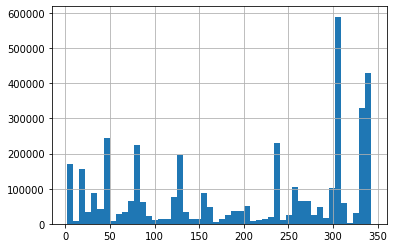

In [72]:
df['categoria_dos'].hist(bins=50)

<hr>

* Atributo `precio`

El precio se detecta como tipo `object` porque usa la coma en vez del punto. Se modifica para poder hacer operaciones con él.

In [73]:
df["precio"] = df["precio"].str.replace(",", ".").astype(float)

In [74]:
df["precio"].dtype

dtype('float64')

In [75]:
print("Max: ", df["precio"].max(), "; Min: ", df["precio"].min(), "; Media: ", df["precio"].mean(),"; STD: ", df["precio"].std())

Max:  175.78 ; Min:  3.57 ; Media:  34.24319426208051 ; STD:  23.309432664059635


<hr>

* Atributo `dia_atipico`

In [76]:
df["dia_atipico"].value_counts()

 0    3505132
 1     398688
-1     141202
Name: dia_atipico, dtype: int64

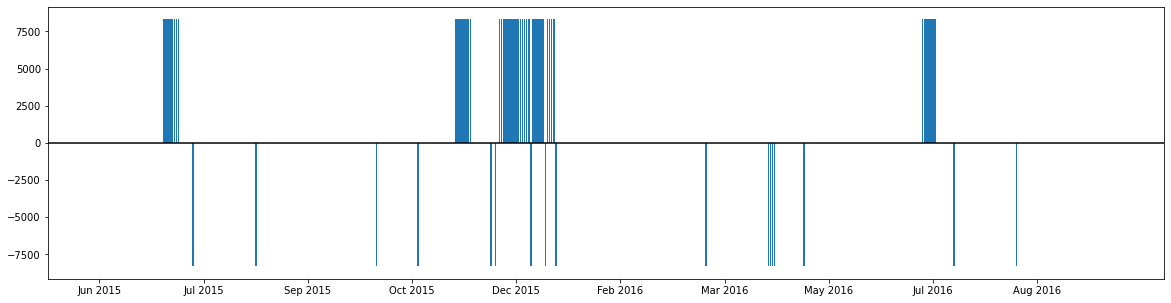

In [77]:
plt.figure(figsize=(20,5)) 
plt.axhline(0, color="black")
plt.bar(range(len(df.groupby(["fecha"]))), 
        df.groupby(["fecha"])["dia_atipico"].sum().to_numpy())

xticks = df["fecha"].unique()[range(0, len(df.groupby(["fecha"])), 50)]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(range(0, len(df.groupby(["fecha"])), 50), 
           [months[tick.astype('datetime64[M]').astype(int) % 12] \
            + " " + str(tick.astype('datetime64[Y]').astype(int) + 1970) for tick in xticks])

plt.show()

`dia_atipico` se puede transformar en tres atributos binarios al ser un atributo categórico nominal utilizando dummy encoders.

In [78]:
df["dia_tipico"] = df["dia_atipico"].map(lambda x: 1 if x==0 else 0)
df["dia_alta_demanda"] = df["dia_atipico"].map(lambda x: 1 if x==1 else 0)
df["dia_baja_demanda"] = df["dia_atipico"].map(lambda x: 1 if x==1 else 0)

<hr>

* Atributo `campaña`

In [79]:
df["campaña"].value_counts()

0    4033689
1      11333
Name: campaña, dtype: int64

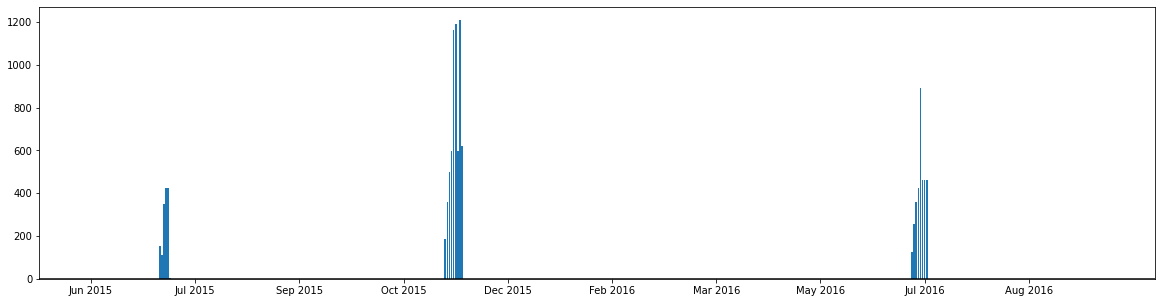

In [80]:
plt.figure(figsize=(20,5)) 
plt.axhline(0, color="black")
plt.bar(range(len(df.groupby(["fecha"]))), 
        df.groupby(["fecha"])["campaña"].sum().to_numpy())

xticks = df["fecha"].unique()[range(0, len(df.groupby(["fecha"])), 50)]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(range(0, len(df.groupby(["fecha"])), 50), 
           [months[tick.astype('datetime64[M]').astype(int) % 12] \
            + " " + str(tick.astype('datetime64[Y]').astype(int) + 1970) for tick in xticks])

plt.show()

<hr>

* Atributo `antiguedad`

<AxesSubplot:>

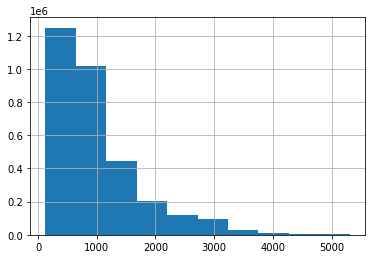

In [81]:
df[df["antiguedad"].notnull()].antiguedad.hist()

<hr>

In [82]:
df.describe(include=['int64', 'float64', 'object'])

,id,visitas,categoria_dos,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,weekday,month,dia_tipico,dia_alta_demanda,dia_baja_demanda
count,4.045022e+06,4.045022e+06,4.039178e+06,1.402111e+06,4.045022e+06,4.045022e+06,3.170857e+06,4.045022e+06,4.045022e+06,4.045022e+06,4.045022e+06,4.045022e+06,4.045022e+06
mean,2.745180e+05,1.721371e+02,2.016524e+02,3.424319e+01,6.365503e-02,2.801715e-03,1.011114e+03,4.693434e+00,2.995893e+00,6.770021e+00,8.665298e-01,9.856263e-02,9.856263e-02
std,8.336719e+04,6.889116e+02,1.179997e+02,2.330943e+01,3.597475e-01,5.285704e-02,7.162509e+02,2.237403e+01,1.994856e+00,3.065421e+00,3.400823e-01,2.980739e-01,2.980739e-01
min,2.197200e+04,0.000000e+00,2.000000e+00,3.570000e+00,-1.000000e+00,0.000000e+00,1.260000e+02,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.122940e+05,7.000000e+00,8.200000e+01,1.652000e+01,0.000000e+00,0.000000e+00,5.240000e+02,0.000000e+00,1.000000e+00,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,2.926720e+05,3.500000e+01,2.360000e+02,2.689000e+01,0.000000e+00,0.000000e+00,7.950000e+02,0.000000e+00,3.000000e+00,7.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,3.379000e+05,1.300000e+02,3.070000e+02,4.535000e+01,0.000000e+00,0.000000e+00,1.244000e+03,3.000000e+00,5.000000e+00,9.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,4.586600e+05,1.200450e+05,3.430000e+02,1.757800e+02,1.000000e+00,1.000000e+00,5.310000e+03,4.881000e+03,6.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00


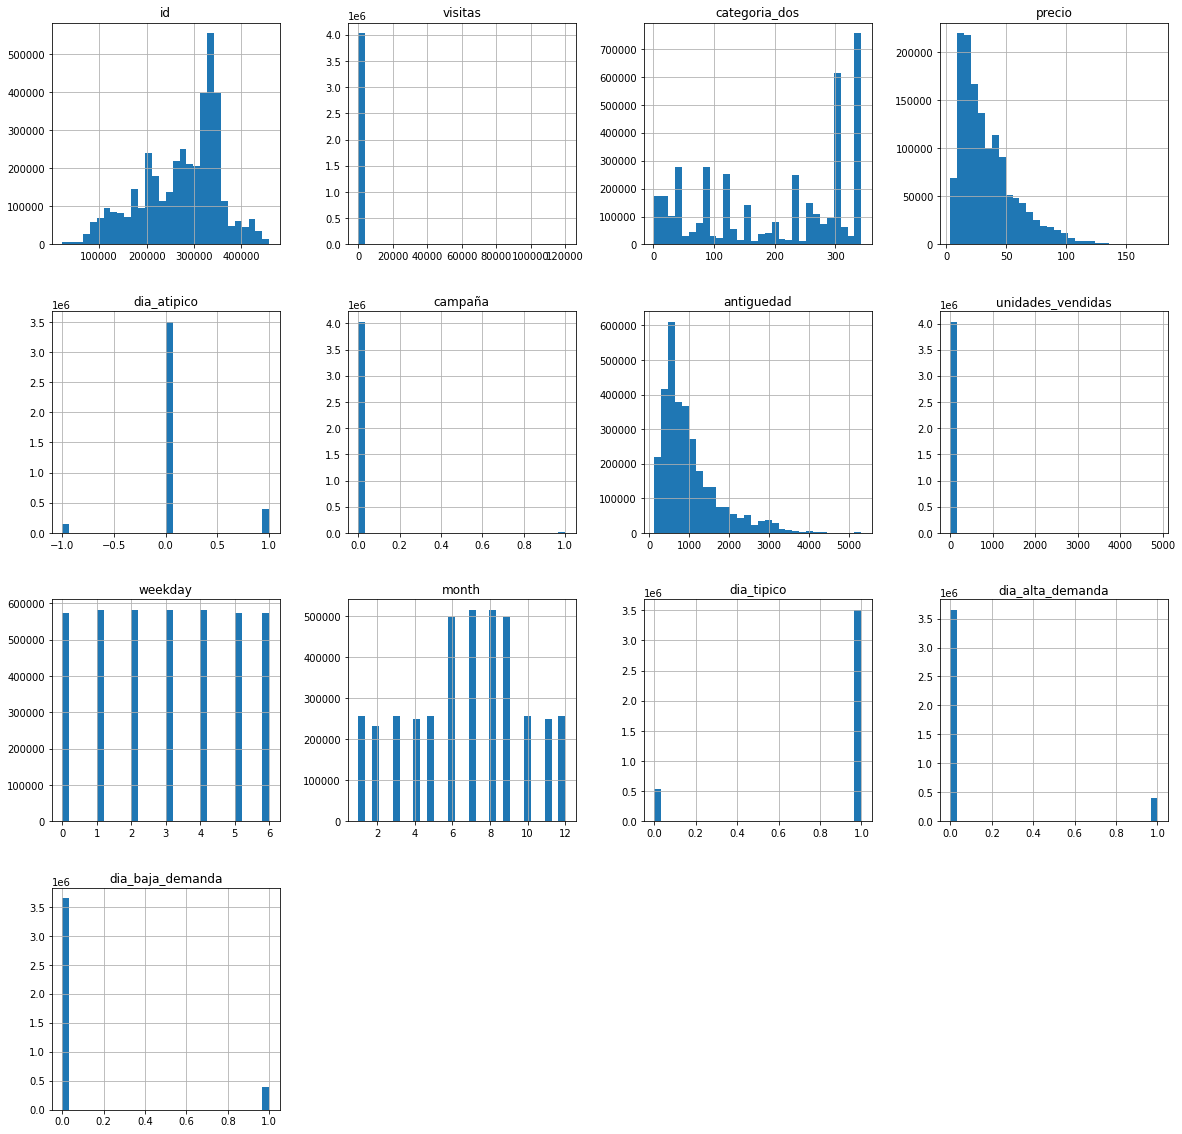

In [83]:
df.hist(bins=30, figsize=(20,20))
plt.show()

### Relaciones entre atributos

Cuando hay campaña no hay casi roturas en comparación con cuando no hay campaña, ya que se debe estar más preparado por si esto pueda ocurrir:

In [84]:
df.groupby(['estado', 'campaña']).size()

estado     campaña
No Rotura  0          3377258
           1            10926
Rotura     0           606426
           1              104
Transito   0            50005
           1              303
dtype: int64

Cuando hay campaña no hay días con menos demanda de la habitual, y no es un factor muy determinante para que haya más demanda de la habitual:

In [85]:
df.groupby(['dia_atipico', 'campaña']).size()

dia_atipico  campaña
-1           0           141202
 0           0          3504811
             1              321
 1           0           387676
             1            11012
dtype: int64

A simple vista no hay una clara relación entre que haya stock del artículo y sea un día atípico:

In [86]:
df.groupby(['estado', 'dia_atipico']).size()

estado     dia_atipico
No Rotura  -1              121568
            0             2923646
            1              342970
Rotura     -1               18303
            0              540057
            1               48170
Transito   -1                1331
            0               41429
            1                7548
dtype: int64

In [87]:
categorias_grouped = df.groupby(['categoria_uno'])

In [88]:
categorias_grouped.agg(
    {"visitas" : ["sum", "mean"],
     "precio" : ["mean", "var"],
     "unidades_vendidas" : ["sum", "mean"]
     }).sort_values(by=('visitas', 'sum'), ascending=False)

visitas                 precio               \
                     sum        mean       mean          var   
categoria_uno                                                  
A              259529032  165.193374  28.135854   182.683630   
H              131427484  268.262058  57.843376   783.411286   
K              117196529  201.549378  40.573421   545.917662   
F              111400556  243.090940  61.494298  1077.673483   
E               38159451  118.362783  26.204836   236.269129   
G               14148611   81.152484  22.021345    71.597622   
L               11817694  102.389503  36.455702   208.404107   
I                4830183   71.871306  27.610438   201.739234   
C                3642222   21.008133   9.483889    14.025237   
O                2632651  360.390281  49.872613   209.907394   
B                1073978   13.697476  16.103079    24.480264   
N                 430117   80.290648  15.309675    14.355162   
D                   9695   19.907598  14.842174     0.657057   

              unidades_vendidas            
                            sum      mean  
categoria_uno                              
A                       9013650  5.737297  
H                       2204586  4.499871  
K                       2829663  4.866329  
F                       1253325  2.734923  
E                       1333656  4.136727  
G                        742929  4.261233  
L                        355317  3.078497  
I                        163605  2.434381  
C                        833883  4.809791  
O                         24405  3.340862  
B                        217794  2.777737  
N                         11223  2.095016  
D                          1008  2.069815

In [89]:
categorias_grouped.agg({"categoria_dos" : ["mean", "min", "max"],})

categoria_dos              
                       mean    min    max
categoria_uno                            
A                161.042171   16.0  343.0
B                249.391304   57.0  312.0
C                120.938202   63.0  170.0
D                264.000000  264.0  264.0
E                165.648402   10.0  323.0
F                279.104701   20.0  341.0
G                174.455307   29.0  298.0
H                270.675622    2.0  326.0
I                160.384058    5.0  331.0
K                233.314070    7.0  340.0
L                247.945148   14.0  296.0
N                204.909091  116.0  278.0
O                226.000000  226.0  226.0

Cuando hay campaña se venden muchos más artículos:

In [90]:
df.groupby(["categoria_uno", "campaña"]).agg({"unidades_vendidas" : ["mean", "var"]})

unidades_vendidas              
                                   mean           var
categoria_uno campaña                                
A             0                5.574576    547.222044
              1               57.789828  18595.451835
B             0                2.761767     36.957297
              1               25.527273   1428.957576
C             0                4.805497    386.925597
              1               24.394737    580.461593
D             0                2.069815     42.484828
              1                     NaN           NaN
E             0                4.004207    692.191218
              1               45.483495  11425.987580
F             0                2.552826    169.967505
              1               67.900548  35563.235399
G             0                4.226818     87.743215
              1               22.409091    842.394446
H             0                4.360649    241.564276
              1               40.165354   8752.114976
I             0                2.369752     55.419969
              1               26.500000   2389.324022
K             0                4.649973    599.279766
              1               99.099099  68094.422929
L             0                2.979498    122.384871
              1               46.758621   7145.976127
N             0                2.076837     22.744843
              1               14.250000    369.642857
O             0                3.227759     89.012652
              1               42.571429   2302.757143

In [91]:
correlation_matrix = df.corr()

In [92]:
correlation_matrix['unidades_vendidas'].sort_values(ascending=False)

unidades_vendidas    1.000000
visitas              0.399514
campaña              0.125326
dia_baja_demanda     0.109395
dia_alta_demanda     0.109395
dia_atipico          0.098565
antiguedad           0.061281
month                0.033420
weekday              0.033419
categoria_dos        0.000579
precio              -0.044440
id                  -0.054405
dia_tipico          -0.087500
Name: unidades_vendidas, dtype: float64

Se puede observar que están bastantes correlacionadas con la unidades vendidas

Se crea un dataset intermedio para poder usarlo en el script de predicción

In [93]:
df.to_csv("./data/Modelar_Intermedio_UH2021.txt", sep="|", date_format="%d/%m/%Y %H:%M:%S", index=False)